# Hamiltonian simulation with Gray code encoding - statevector simulator

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [5]:
from scipy.linalg import eigh

## H is always in qiskit order (right to left)
## String form is also in that order 

## State vector results in order [00,01,10,11]

n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
Exact_energies,_=eigh(H.matrix)
print("N=4 ground state:", Exact_energies[0])

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}
N=4 ground state: -2.143981030799861


In [6]:

##testing state initialization 
if False:    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
#     init=np.random.uniform(0,1,2**n_qubits)
#     init=init/np.sqrt(init.dot(init))

    print("initialization vector",init)
    print(init.dot(init))

    circuit = initialize_circuit(q,c,initial_state=init)
    backend = 'statevector_simulator'
    
    job = execute(circuit, Aer.get_backend(backend),shots=n_shots)
    
    state_vector=job.result().get_statevector(circuit)
    counts = job.result().get_counts(circuit)
    n_shots = sum(counts.values())
    print("state vector : ",state_vector)
    print("num shots :",n_shots)
    print("counts :",counts)
    print(sum(counts.values()))
    
    print()

A_set=[]
n_qubits=2
pauli_id="I"*n_qubits

state_vector=run_circuit_statevector(n_qubits,A_set,initialization=None)


counts=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=10000,initialization=None)
vec=[]
for state in counts:
    vec.append(np.sqrt(counts[state]))
    
print(state_vector)
print(counts)
print(vec)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
{'00': 1.0}
[1.0]


In [7]:
n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
# print(H.N_qubits)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}


In [8]:
## vector of WeightedPauliOperators representing vector Sigma

## Get list of sigmas (all pauli terms with odd number Y gates)
sigmas=get_sigma_pauli_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])
    


XX ['II', 'IX', 'XI', 'XX'] XX
XY ['IY', 'XY'] YX
XZ ['IZ', 'XZ'] ZX
YX ['YI', 'YX'] XY
YY ['YY'] YY
YZ ['YZ'] ZY
ZX ['ZI', 'ZX'] XZ
ZY ['ZY'] YZ
ZZ ['ZZ'] ZZ


In [9]:
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=3
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

backend = 'statevector_simulator'
sv_energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for threshold in [1e-1,1e-2,1e-5,1e-10]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold)
    Energy_table.append(Energies)




100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


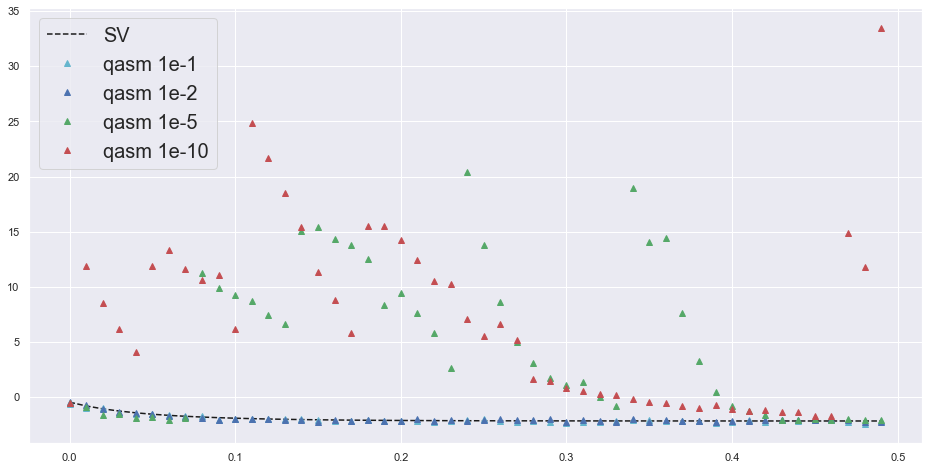

In [16]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

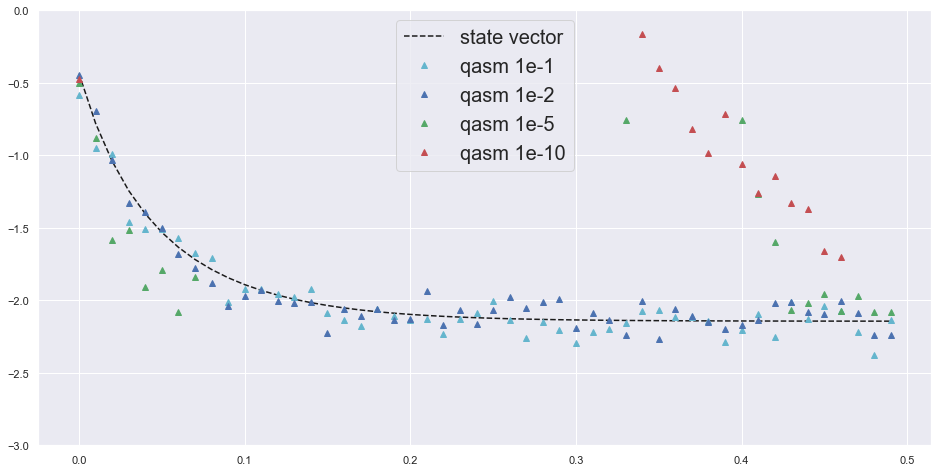

In [17]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="state vector")
# plt.plot(time,Energy_table[0],'c^',label="qasm 1")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.ylim(-3,0)
plt.legend(prop={'size': 20})

In [11]:
### Testing  time steps 
num_iterations=50
verbose=False
initialization="zeros"

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

# backend = 'statevector_simulator'
# sv_energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for delta_time in [0.001,0.01,0.1]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_qasm.append(Energies)

    backend = 'statevector_simulator'
    Energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_sv.append(Energies)

    


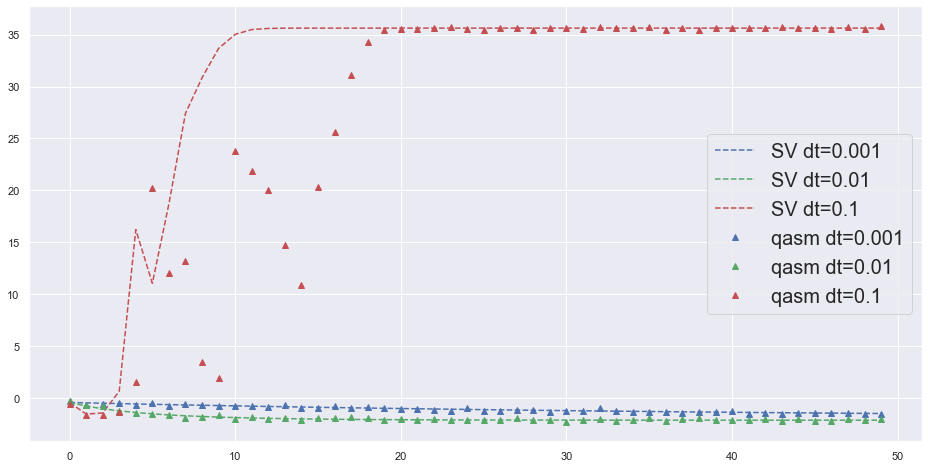

In [46]:
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.1")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.1")
plt.legend(prop={'size': 20})

(-3.0, 0.0)

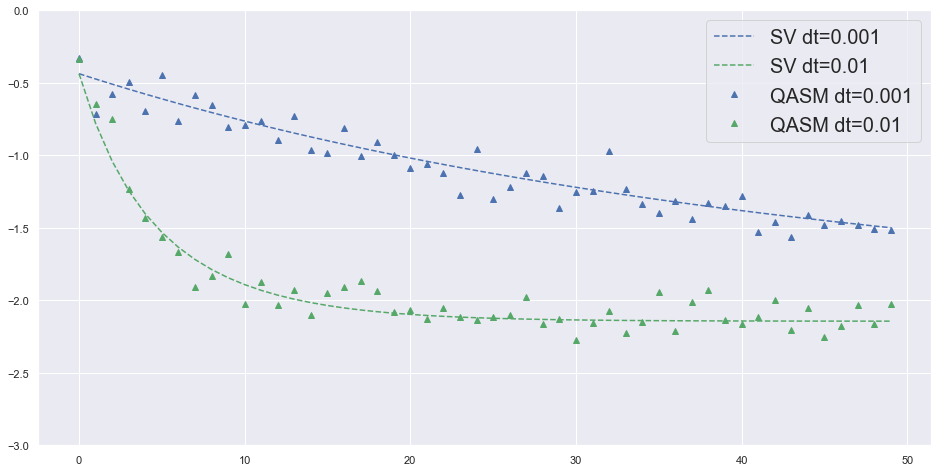

In [22]:

time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
# plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.01")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="QASM dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="QASM dt=0.01")
# plt.plot(time,Energy_table_time_qasm[2],'r^',label="QASM dt=0.1")

plt.legend(prop={'size': 20})
plt.ylim(-3,0)

In [21]:
## Combining A 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_step=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

for cs in range(0,num_iterations,10):
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step.append(Energies)

0
10
20
30
40


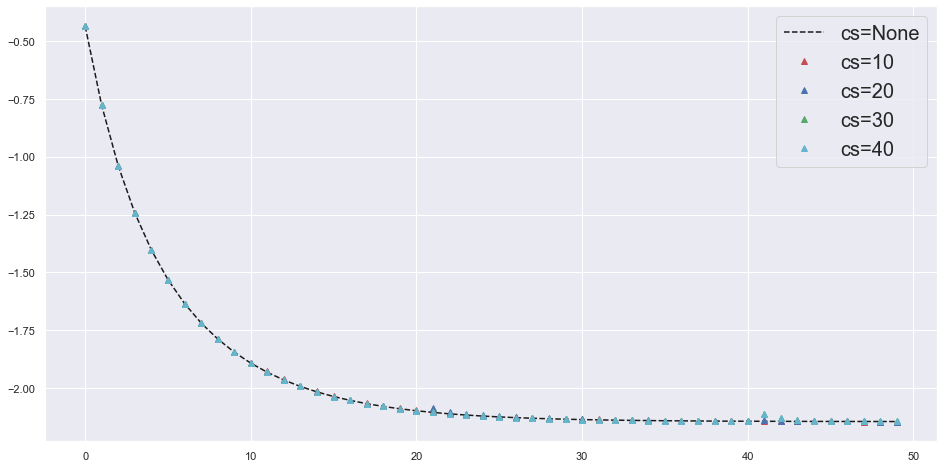

In [47]:
for cs in range(0,50,10):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r^',label="cs=10")
plt.plot(time,Energy_table_step[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step[4],'g^',label="cs=30")
plt.plot(time,Energy_table_step[4],'c^',label="cs=40")
plt.plot()
plt.legend(prop={'size': 20})

0
5
10
15
20
25


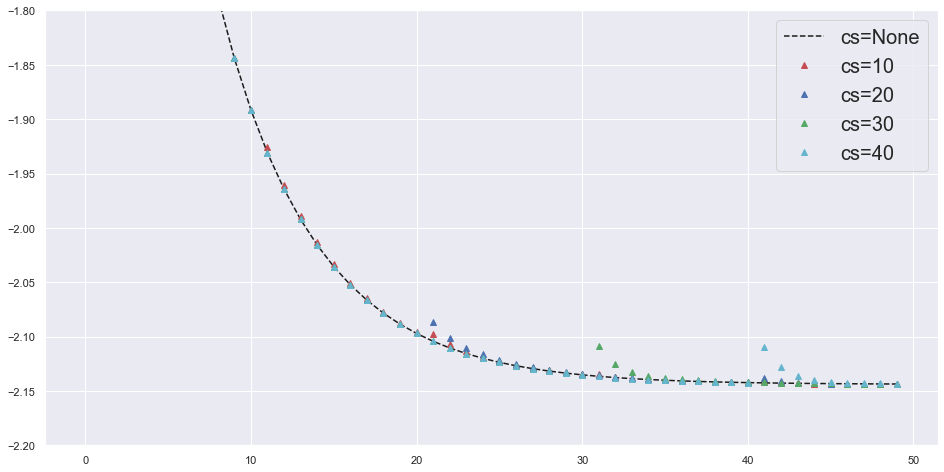

In [45]:
for cs in range(0,30,5):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r^',label="cs=10")
plt.plot(time,Energy_table_step[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step[3],'g^',label="cs=30")
plt.plot(time,Energy_table_step[4],'c^',label="cs=40")
plt.ylim(-2.2,-1.8)
plt.plot()
plt.legend(prop={'size': 20})


In [25]:
## Combining A 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

Energy_table_step_qasm=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

for cs in range(0,num_iterations,10):
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step_qasm.append(Energies)

0
10
20
30
40


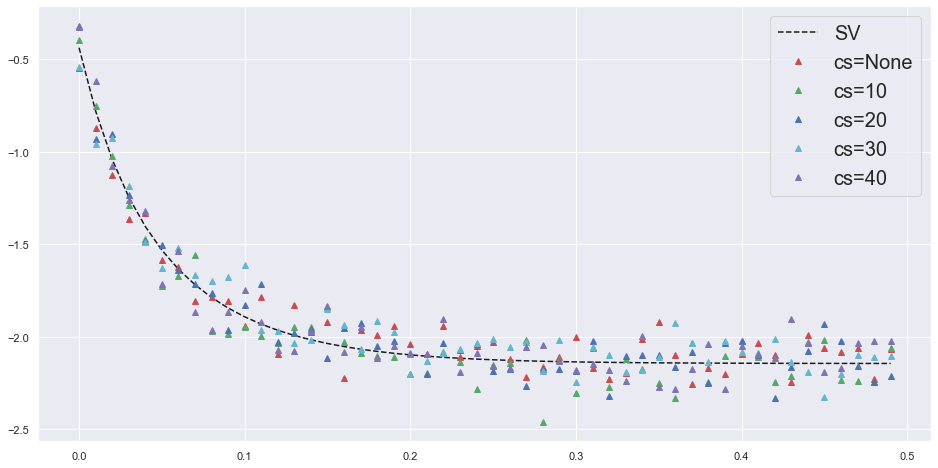

In [44]:
for cs in range(0,50,10):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[0.01*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=10")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step_qasm[3],'c^',label="cs=30")
plt.plot(time,Energy_table_step_qasm[4],'m^',label="cs=40")
plt.plot()
plt.legend(prop={'size': 20})

## N=8

In [25]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
n_qubits=3

H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
sv_energies,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)
print(sv_energies)


100%|██████████| 100/100 [03:30<00:00,  2.11s/it]

[-0.43658111 -0.77894413 -1.04042231 -1.24345887 -1.40342211 -1.53109042
 -1.6341742  -1.71828488 -1.78756962 -1.84513645 -1.8933447  -1.93400657
 -1.96852927 -1.99801666 -2.02334273 -2.04520558 -2.06416729 -2.08068384
 -2.09512777 -2.10780541 -2.11897025 -2.12883325 -2.13757094 -2.14533185
 -2.15224157 -2.15840679 -2.1639186  -2.16885507 -2.17328345 -2.17726186
 -2.18084076 -2.18406412 -2.18697037 -2.18959323 -2.19196237 -2.19410399
 -2.19604127 -2.19779479 -2.19938284 -2.20082174 -2.20212605 -2.20330883
 -2.20438177 -2.20535535 -2.20623902 -2.20704126 -2.20776974 -2.20843136
 -2.20903236 -2.20957836 -2.21007447 -2.21052529 -2.210935   -2.21130738
 -2.21164586 -2.21195354 -2.21223325 -2.21248754 -2.21271873 -2.21292892
 -2.21312004 -2.21329382 -2.21345183 -2.21359552 -2.21372617 -2.21384499
 -2.21395303 -2.21405128 -2.21414063 -2.21422188 -2.21429578 -2.21436297
 -2.21442409 -2.21447966 -2.21453021 -2.21457617 -2.21461798 -2.21465599
 -2.21469057 -2.21472201 -2.21475061 -2.21477662 -2

In [26]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
n_qubits=3

sv_energies_table_cs=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
for cs in range(10,51,10):
    sv_energies_table_cs.append(run_qite_experiment(H,num_iterations,delta_time,backend,initialization,cstep=cs)[0])

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


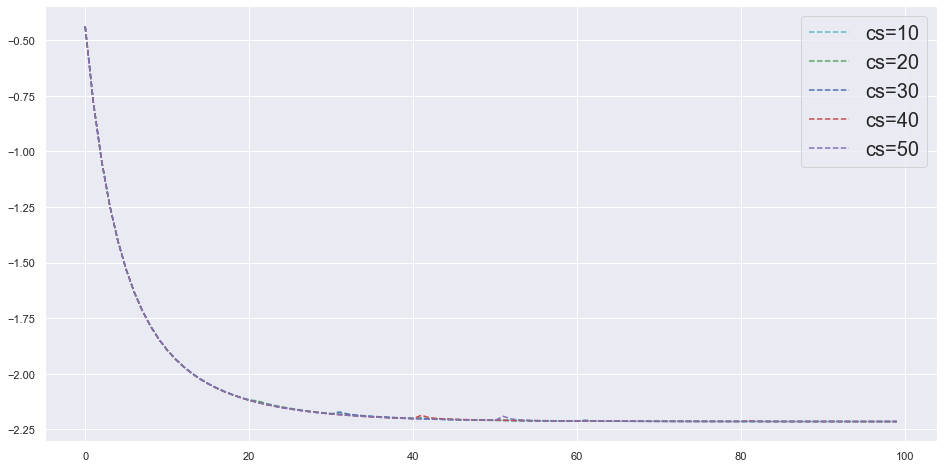

In [27]:
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.legend(prop={'size': 20})

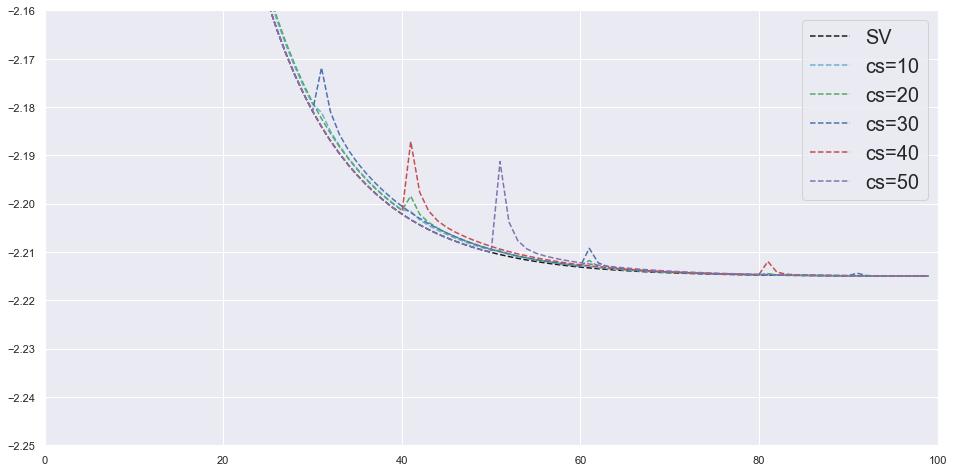

In [28]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.xlim(0,100)
plt.ylim(-2.25,-2.16)
plt.legend(prop={'size': 20})

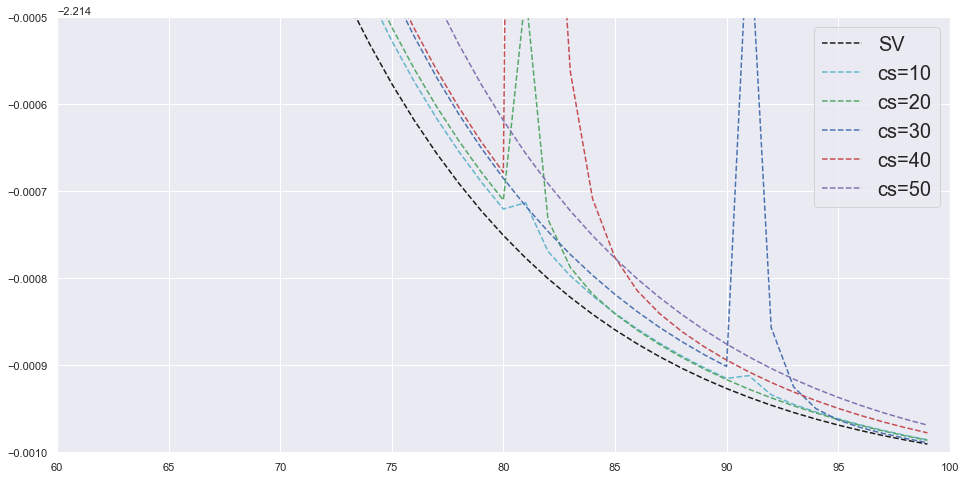

In [29]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.xlim(60,100)
plt.ylim(-2.2150,-2.2145)
plt.legend(prop={'size': 20})

In [13]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
n_qubits=3
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
sv_energies_3q_100=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [11]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"
n_qubits=3

qasm_energies_table_cs=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
for cs in range(10,31,10):
    qasm_energies_table_cs.append(run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0])

100%|██████████| 100/100 [49:11<00:00, 29.52s/it] 


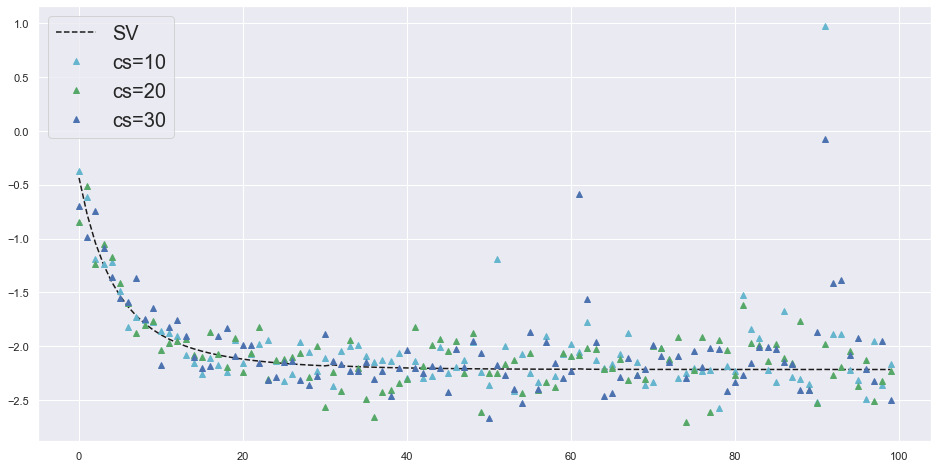

In [19]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies_3q_100,'k--',label="SV")
plt.plot(time,qasm_energies_table_cs[0],'c^',label="cs=10")
plt.plot(time,qasm_energies_table_cs[1],'g^',label="cs=20")
plt.plot(time,qasm_energies_table_cs[2],'b^',label="cs=30")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

In [10]:
num_iterations=50
delta_time=0.01
verbose=False

initialization="zeros"
n_qubits=3


H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
backend = 'qasm_simulator'
qasm_energies_q3,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=None)
backend = 'statevector_simulator'
sv_energies_q3,_=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,cstep=None)

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


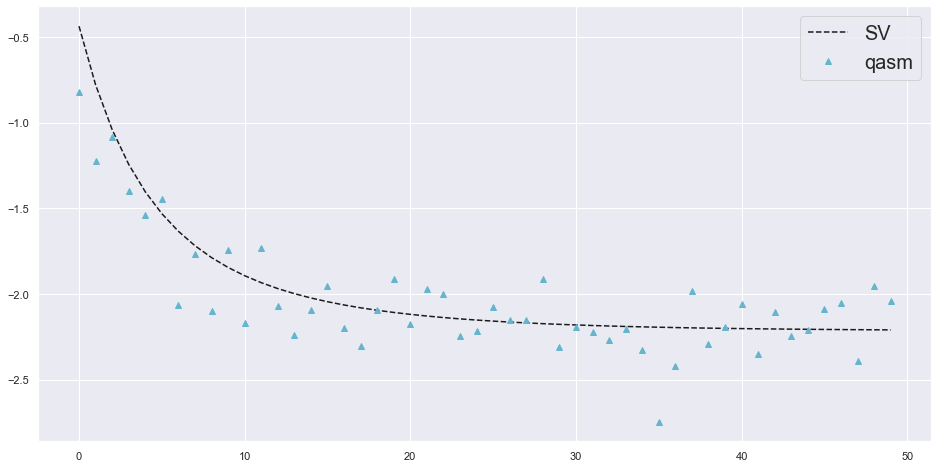

In [14]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies_q3,'k--',label="SV")
plt.plot(time,qasm_energies_q3,'c^',label="qasm")
plt.legend(prop={'size': 20})